# Bayesian Regression Example for ML w/ Prob Prog

Adapted from http://pyro.ai/examples/bayesian_regression_ii.html

In [1]:
import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
import pyro.optim as optim

from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, Predictive
from pyro.contrib.autoguide import AutoMultivariateNormal
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS

pyro.set_rng_seed(1)
assert pyro.__version__.startswith('1.4.0')

In [2]:
%matplotlib inline
plt.style.use('default')

logging.basicConfig(format='%(message)s', level=logging.INFO)
# Enable validation checks
pyro.enable_validation(True)
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)

In [3]:
rugged_data = pd.read_csv('rugged_data.csv', encoding='ISO-8859-1')

## Bayesian Linear Regression

Our goal is once again to predict log GDP per capita of a nation as a function of two features from the dataset - whether the nation is in Africa, and its Terrain Ruggedness Index, but we will explore more expressive guides.

## Model + Training Helper

We will write out the model again, similar to that in [Part I](bayesian_regression.ipynb), but explicitly without the use of `nn.Module`.  We will write out each term in the regression, using the same priors. `bA` and `bR` are regression coefficients corresponding to  `is_cont_africa` and `ruggedness`, `a` is the intercept, and `bAR` is the correlating factor between the two features.

Writing down a guide will proceed in close analogy to the construction of our model, with the key difference that the guide parameters need to be trainable. To do this we register the guide parameters in the ParamStore using `pyro.param()`. Note the positive constraints on scale parameters.

In [4]:
# Prepare training data
df = rugged_data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
train = torch.tensor(df.values, dtype=torch.float)

is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

In [5]:
def model(is_cont_africa, ruggedness, log_gdp):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
    with pyro.plate("data", len(ruggedness)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

In [6]:
def train_via_opt(model, guide, lr=0.05):
    pyro.clear_param_store()
    svi = SVI(model, guide, optim.Adam({"lr": lr}), loss=Trace_ELBO())

    n_steps = 2000
    for step in range(n_steps):
        loss = svi.step(is_cont_africa, ruggedness, log_gdp)
        if step % 250 == 0:
            print('[iter {}]  loss: {:.4f}'.format(step, loss))

In [7]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

# MAP

In [8]:
def guide_map(is_cont_africa, ruggedness, log_gdp):
    a = pyro.sample("a", dist.Delta(pyro.param("a_map", torch.tensor(0.0))))
    b_a = pyro.sample("bA", dist.Delta(pyro.param("bA_map", torch.tensor(0.0))))
    b_r = pyro.sample("bR", dist.Delta(pyro.param("bR_map", torch.tensor(0.0))))
    b_ar = pyro.sample("bAR", dist.Delta(pyro.param("bAR_map", torch.tensor(0.0))))
    sigma = pyro.sample("sigma", dist.Delta(pyro.param("sigma_map", torch.tensor(1.0), constraint=constraints.positive)))
    
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

In [9]:
train_via_opt(model, guide_map)

[iter 0]  loss: 6445.4894
[iter 250]  loss: 484.9884
[iter 500]  loss: 416.9855
[iter 750]  loss: 314.1581
[iter 1000]  loss: 240.1045
[iter 1250]  loss: 239.9596
[iter 1500]  loss: 239.9596
[iter 1750]  loss: 239.9596


In [10]:
map_estimates = {}
map_estimates["a"] = pyro.param("a_map").item()
map_estimates["bA"] = pyro.param("bA_map").item()
map_estimates["bR"] = pyro.param("bR_map").item()
map_estimates["bAR"] = pyro.param("bAR_map").item()
map_estimates["sigma"] = pyro.param("sigma_map").item()

In [11]:
print(f'MAP estimate of a     : {pyro.param("a_map").item()}')
print(f'MAP estimate of bA    : {pyro.param("bA_map").item()}')
print(f'MAP estimate of bR    : {pyro.param("bR_map").item()}')
print(f'MAP estimate of bAR   : {pyro.param("bAR_map").item()}')
print(f'MAP estimate of sigma : {pyro.param("sigma_map").item()}')

MAP estimate of a     : 9.181869506835938
MAP estimate of bA    : -1.84445059299469
MAP estimate of bR    : -0.183599591255188
MAP estimate of bAR   : 0.34759393334388733
MAP estimate of sigma : 0.9332681894302368


## SVI

As before, we will use SVI to perform inference.

In [12]:
def guide(is_cont_africa, ruggedness, log_gdp):
    a_loc = pyro.param('a_loc', torch.tensor(0.))
    a_scale = pyro.param('a_scale', torch.tensor(1.),
                         constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', torch.tensor(1.),
                             constraint=constraints.positive)
    weights_loc = pyro.param('weights_loc', torch.randn(3))
    weights_scale = pyro.param('weights_scale', torch.ones(3),
                               constraint=constraints.positive)
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

In [13]:
train_via_opt(model, guide)

[iter 0]  loss: 5795.4676
[iter 250]  loss: 470.5512
[iter 500]  loss: 415.8169
[iter 750]  loss: 337.3592
[iter 1000]  loss: 250.7192
[iter 1250]  loss: 248.4504
[iter 1500]  loss: 247.1946
[iter 1750]  loss: 257.9461


In [14]:
num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(log_gdp, is_cont_africa, ruggedness).items()
               if k != "obs"}

Let us observe the posterior distribution over the different latent variables in the model.

In [15]:
for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
       mean       std        5%      25%       50%       75%       95%
0  9.168211  0.073397  9.047412  9.11546  9.170982  9.217868  9.286436 

Site: bA
       mean       std        5%       25%       50%      75%      95%
0 -1.871367  0.137225 -2.103835 -1.965004 -1.868791 -1.77526 -1.64328 

Site: bR
       mean       std        5%       25%       50%       75%       95%
0 -0.165118  0.047072 -0.238561 -0.197682 -0.165362 -0.133217 -0.086291 

Site: bAR
       mean       std        5%       25%       50%       75%       95%
0  0.341086  0.086507  0.202646  0.285631  0.338853  0.396382  0.487786 

Site: sigma
       mean       std        5%      25%       50%       75%       95%
0  0.962458  0.050296  0.879167  0.92956  0.961202  0.996295  1.044771 



## HMC

In contrast to using variational inference which gives us an approximate posterior over our latent variables, we can also do exact inference using [Markov Chain Monte Carlo](http://docs.pyro.ai/en/dev/mcmc.html) (MCMC), a class of algorithms that in the limit, allow us to draw unbiased samples from the true posterior. The algorithm that we will be using is called the No-U Turn Sampler (NUTS) \[1\], which provides an efficient and automated way of running Hamiltonian Monte Carlo.  It is slightly slower than variational inference, but provides an exact estimate.

In [16]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(is_cont_africa, ruggedness, log_gdp)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Sample: 100%|██████████| 1200/1200 [00:27, 43.63it/s, step size=3.41e-01, acc. prob=0.932]


In [17]:
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
       mean       std        5%      25%       50%       75%      95%
0  9.186877  0.138838  8.958779  9.09328  9.189491  9.274171  9.42897 

Site: bA
       mean       std        5%       25%       50%       75%       95%
0 -1.859916  0.223591 -2.225528 -2.020191 -1.854385 -1.707892 -1.517022 

Site: bR
       mean       std        5%       25%       50%       75%       95%
0 -0.187301  0.078942 -0.314141 -0.238675 -0.186967 -0.131882 -0.054502 

Site: bAR
       mean       std        5%       25%       50%       75%       95%
0  0.359185  0.129782  0.147538  0.277808  0.358398  0.442401  0.568684 

Site: sigma
       mean       std        5%       25%       50%       75%       95%
0  0.952456  0.053048  0.871549  0.916451  0.951075  0.984877  1.048475 



## Comparing Posterior Distributions

Let us compare the posterior distribution of the latent variables that we obtained from variational inference with those from Hamiltonian Monte Carlo. As can be seen below, for Variational Inference, the marginal distribution of the different regression coefficients is under-dispersed w.r.t. the true posterior (from HMC). This is an artifact of the *KL(q||p)* loss (the KL divergence of the true posterior from the approximate posterior) that is minimized by Variational Inference.

This can be better seen when we plot different cross sections from the joint posterior distribution overlaid with the approximate posterior from variational inference. Note that since our variational family has diagonal covariance, we cannot model any correlation between the latents and the resulting approximation is overconfident (under-dispersed)

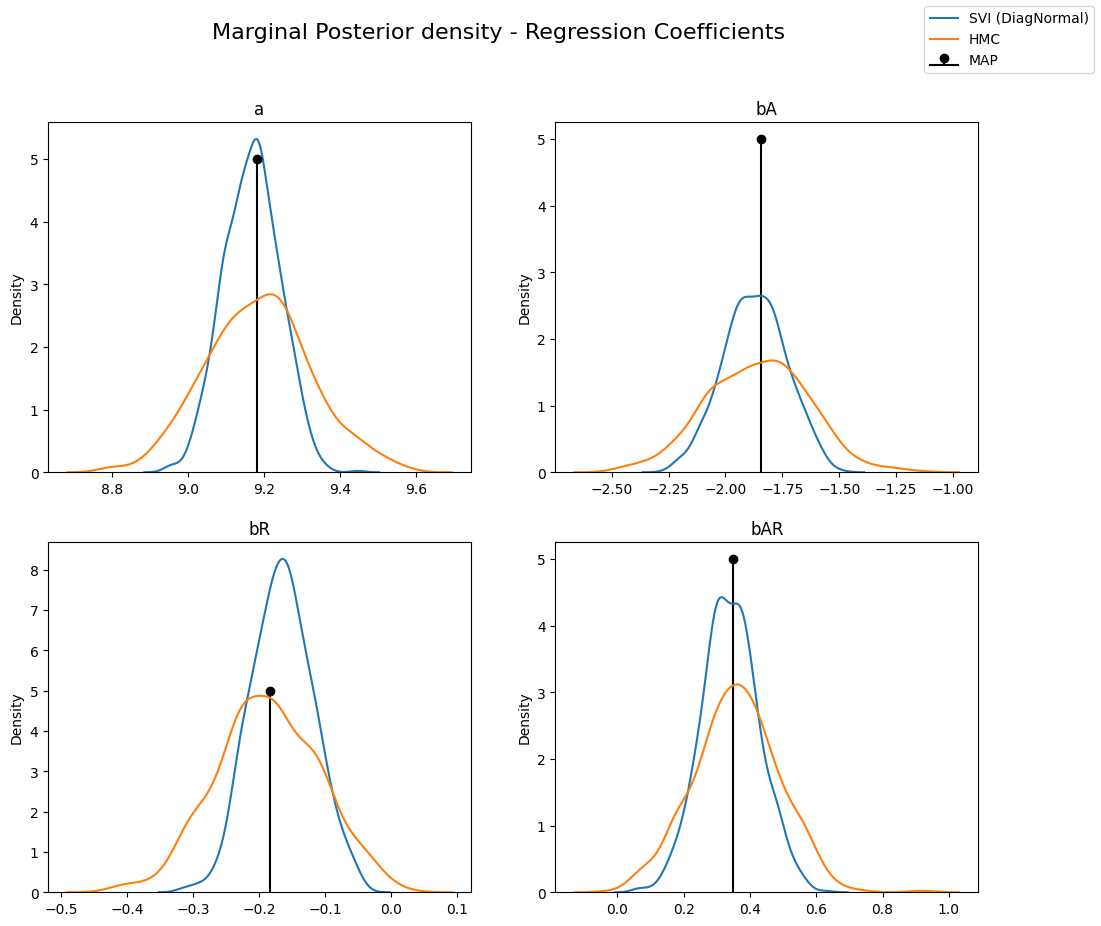

In [18]:
sites = ["a", "bA", "bR", "bAR", "sigma"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.kdeplot(svi_samples[site], ax=ax, label="SVI (DiagNormal)", color='tab:blue', alpha=0.2)
    sns.kdeplot(hmc_samples[site], ax=ax, label="HMC", color="tab:orange", alpha=0.2)
    ax.stem([map_estimates[site]], [5], label="MAP", markerfmt="ko", basefmt='k', linefmt='k')
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

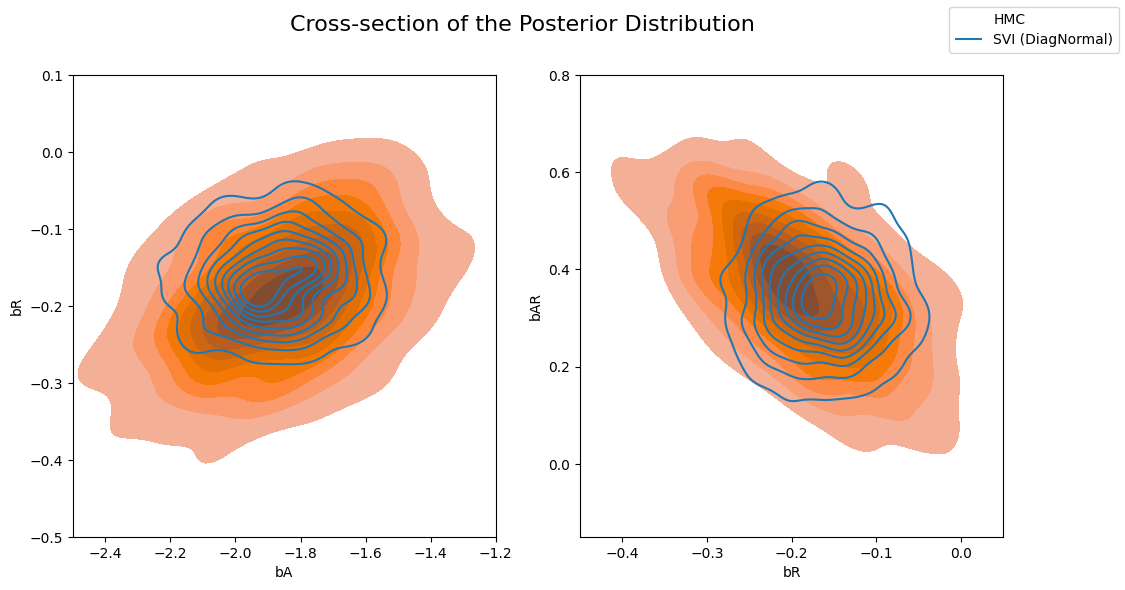

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-section of the Posterior Distribution", fontsize=16)
sns.kdeplot(hmc_samples["bA"], y=hmc_samples["bR"], ax=axs[0], shade=True, label="HMC", color="tab:orange")
sns.kdeplot(svi_samples["bA"], y=svi_samples["bR"], ax=axs[0], label="SVI (DiagNormal)")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(hmc_samples["bR"], y=hmc_samples["bAR"], ax=axs[1], shade=True, label="HMC", color="tab:orange")
sns.kdeplot(svi_samples["bR"], y=svi_samples["bAR"], ax=axs[1], label="SVI (DiagNormal)")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

## MultivariateNormal Guide

As comparison to the previously obtained results from Diagonal Normal guide, we will now use a guide that generates samples from a Cholesky factorization of a multivariate normal distribution.  This allows us to capture the correlations between the latent variables via a covariance matrix.  If we wrote this manually, we would need to combine all the latent variables so we could sample a Multivarite Normal jointly.

In [20]:
from pyro.infer.autoguide.initialization import init_to_mean

guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)

train_via_opt(model, guide, lr=0.01)

[iter 0]  loss: 681.1718
[iter 250]  loss: 531.3409
[iter 500]  loss: 431.2437
[iter 750]  loss: 359.1847
[iter 1000]  loss: 266.1722
[iter 1250]  loss: 249.1281
[iter 1500]  loss: 248.6330
[iter 1750]  loss: 248.0745


Let's look at the shape of the posteriors again.  You can see the multivariate guide is able to capture more of the true posterior.

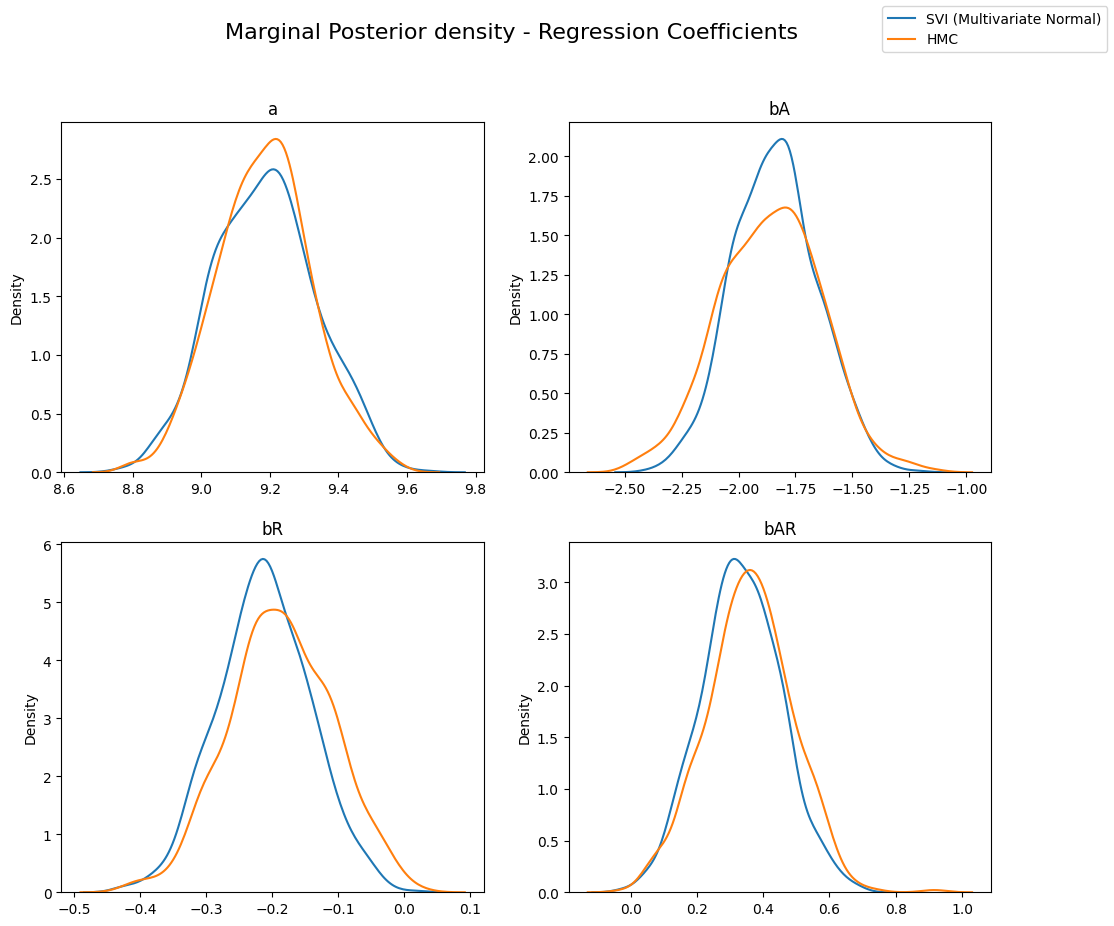

In [21]:
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_mvn_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
                   for k, v in predictive(log_gdp, is_cont_africa, ruggedness).items()
                   if k != "obs"}
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.kdeplot(svi_mvn_samples[site], ax=ax, label="SVI (Multivariate Normal)")
    sns.kdeplot(hmc_samples[site], ax=ax, label="HMC")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

Now let's compare the posterior computed by the Diagonal Normal guide vs the Multivariate Normal guide.  Note that the multivariate distribution is more dispresed than the Diagonal Normal.

and the Multivariate guide with the posterior computed by HMC.  Note that the Multivariate guide better captures the true posterior.

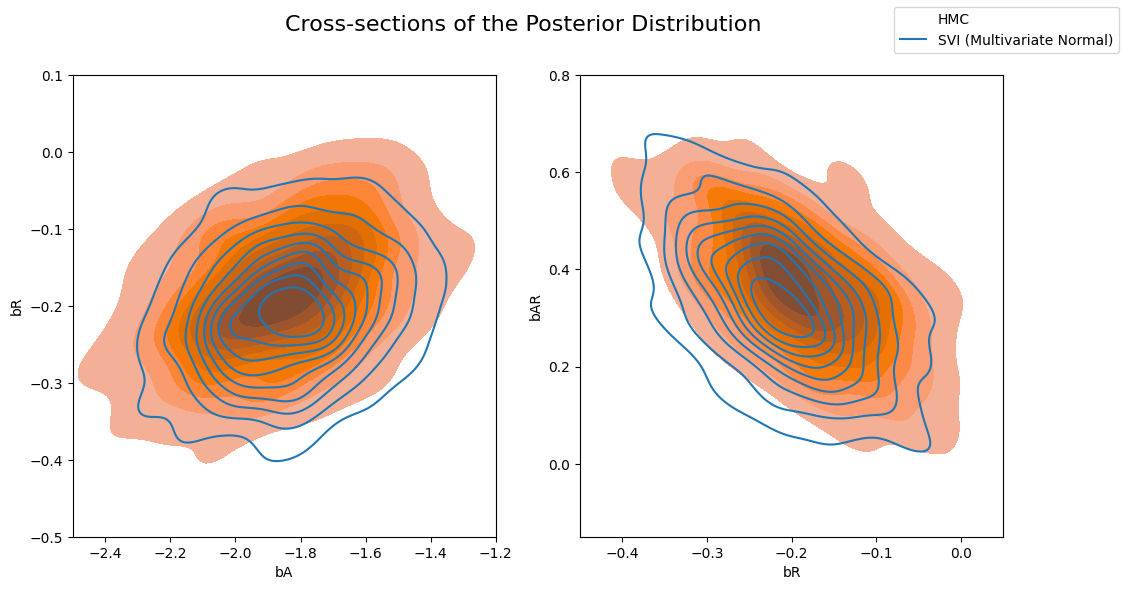

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)
sns.kdeplot(hmc_samples["bA"], y=hmc_samples["bR"], ax=axs[0], shade=True, label="HMC", color="tab:orange")
sns.kdeplot(svi_mvn_samples["bA"], y=svi_mvn_samples["bR"], ax=axs[0], label="SVI (Multivariate Normal)")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(hmc_samples["bR"], y=hmc_samples["bAR"], ax=axs[1], shade=True, label="HMC", color="tab:orange")
sns.kdeplot(svi_mvn_samples["bR"], y=svi_mvn_samples["bAR"], ax=axs[1], label="SVI (Multivariate Normal)")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

## References
[1] Hoffman, Matthew D., and Andrew Gelman. "The No-U-turn sampler: adaptively setting path lengths in Hamiltonian Monte Carlo." Journal of Machine Learning Research 15.1 (2014): 1593-1623.  https://arxiv.org/abs/1111.4246.